<a href="https://colab.research.google.com/github/james-r-barrett/oxysolve/blob/main/oxygen_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oxygen electrode data analysis

# 1. Upload raw csv file from oxygen electrode.

In [ ]:
# @title File upload
import os
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

basename = os.path.splitext(fn)[0]

Saving 9X_12h_1.csv to 9X_12h_1 (1).csv
User uploaded file "9X_12h_1 (1).csv" with length 669224 bytes


# 2. Define window over which the rate will be calculated for the plots.

In [ ]:
# @title Enter window size for initial rate calculation and select data type
import ipywidgets as widgets
from IPython.display import display

# Window size input
window_size_input = widgets.BoundedIntText(
    value=15,  # Default value
    min=1,
    max=100,
    step=1,
    description="Window size for rate calculation (seconds):",
    style={'description_width': 'initial'}
)

# Dropdown for data type
data_type_dropdown = widgets.Dropdown(
    options=["CO₂ response", "Light response"],
    value="CO₂ response",
    description="Data type:",
    style={'description_width': 'initial'}
)

# Display widgets
display(window_size_input, data_type_dropdown)

BoundedIntText(value=15, description='Window size for rate calculation (seconds):', min=1, style=DescriptionSt…

Dropdown(description='Data type:', options=('CO₂ response', 'Light response'), style=DescriptionStyle(descript…

# 3. Execute analysis script.

In [ ]:
# @title Perform analysis
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox, HBox
import ipywidgets as widgets

widgets.FloatSlider()
from google.colab import files
import os

# ---------------------------
# Load Data
# ---------------------------
# uploaded = files.upload()
# fn = list(uploaded.keys())[0]
filename = fn
basename = os.path.splitext(fn)[0]

default_window_size = window_size_input.value  # seconds
data_type = data_type_dropdown.value
print(data_type)

with open(fn, 'rb') as f:
    result = chardet.detect(f.read(10000))

encoding_used = result['encoding']

if data_type == "CO₂ response":
    skip_rows = 28
    expected_cols = 7
    column_names = ['Time', 'Oxygen 1', 'Rate 1', 'Label', 'Trace', 'Type', 'Comment']
elif data_type == "Light response":
    skip_rows = 75
    expected_cols = 8
    column_names = ['Time', 'Oxygen 1', 'Rate 1', 'Label', 'Trace', 'Type', 'Comment', 'Light level']

df = pd.read_csv(
    filename,
    skiprows=skip_rows,
    encoding=encoding_used,
    header=None,
    dtype=str,
    engine='python',
    on_bad_lines='skip'  # or 'warn' if you want to see issues
)

# Keep only the first N columns
df = df.iloc[:, :expected_cols]

df.columns = column_names

df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df['Oxygen 1'] = pd.to_numeric(df['Oxygen 1'], errors='coerce')
df['numeric_label'] = pd.to_numeric(df['Label'], errors='coerce')

first_valid_index = df['numeric_label'].first_valid_index()
if first_valid_index is not None:
    df = df.loc[first_valid_index:].copy()
else:
    raise ValueError("No valid numeric labels found in 'Label' column.")

df['group'] = df['Label'].notna().cumsum()
chunks = {}

# Global list to store all recorded rates
all_recorded_rates = []

# Create a list of all groups
all_groups = list(df.groupby('group'))

# Exclude the last group
all_groups = all_groups[:-1]

# Loop through all groups except the last one
for group, gdf in all_groups:
    if gdf['Label'].notna().any():
        meas_label = gdf['Label'].dropna().iloc[0]
        gdf = gdf.copy()
        gdf["group"] = group
        chunks[group] = {"data": gdf, "meas_label": meas_label, "precalculated_rates": {}}

# Update the main df with group info
df.loc[gdf.index, "group"] = group

df["User Fit"] = np.nan  # New column for storing fit values
df["User Fit R²"] = np.nan  # New column for fit R²


# ---------------------------
# Pre-calculate Rates
# ---------------------------
def precalculate_rates(info, window_size):
    gdf = info["data"].copy()
    time_arr = gdf['Time'].values
    oxygen_arr = gdf['Oxygen 1'].values
    rates = []
    rate_starts = []
    r_squareds = []

    for i in range(len(time_arr)):
        t_start = time_arr[i]
        t_end = t_start + window_size
        if t_end > time_arr[-1]:
            break

        mask = (time_arr >= t_start) & (time_arr <= t_end)
        if np.sum(mask) >= 2:
            t_window = time_arr[mask]
            o_window = oxygen_arr[mask]
            slope, intercept = np.polyfit(t_window, o_window, 1)
            fit = slope * t_window + intercept
            ss_res = np.sum((o_window - fit) ** 2)
            ss_tot = np.sum((o_window - np.mean(o_window)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            rates.append(slope)
            rate_starts.append(t_start)
            r_squareds.append(r2)

    return {"times": rate_starts, "rates": rates, "r_squareds": r_squareds}


# ---------------------------
# Create Widgets Per Chunk
# ---------------------------
def make_chunk_widget(group, info):
    gdf = info["data"]
    time_arr = gdf['Time'].values
    oxygen_arr = gdf['Oxygen 1'].values
    meas_label = info["meas_label"]
    min_t = time_arr.min()
    max_t = time_arr.max()

    if max_t <= min_t:
        return widgets.HTML(f"<b>Chunk {group} (Label {meas_label}): Too short.</b>")

    default_window_size = window_size_input.value
    info["precalculated_rates"][default_window_size] = precalculate_rates(info, default_window_size)

    window_target = int(
        972 * ((max_t - min_t - default_window_size) / (max_t - min_t))) if max_t > min_t + default_window_size else 900

    window_slider = widgets.FloatSlider(
        value=min_t,
        min=min_t,
        max=max_t - default_window_size,
        step=0.5,
        description='Start:',
        continuous_update=True  # Changed to False
    )
    window_slider.layout = widgets.Layout(width=str(window_target) + 'px', margin='0 0 0 15px')

    size_slider = widgets.FloatSlider(
        value=default_window_size,
        min=1.0,
        max=max_t - min_t,
        step=0.5,
        description='Rate calculation window size (s):',
        continuous_update=False,
        layout=widgets.Layout(width='25%')
    )

    record_output = widgets.Output()
    record_button = widgets.Button(description="Record rate", button_style='success')

    out = widgets.Output()

    recorded_rates = []

    def update_plot(change=None):
        with out:
            clear_output(wait=True)

            start = window_slider.value
            size = size_slider.value
            end = start + size
            if end > max_t:
                end = max_t
                start = end - size

            if size not in info["precalculated_rates"]:
                info["precalculated_rates"][size] = precalculate_rates(info, size)

            rate_data = info["precalculated_rates"][size]
            rate_times = rate_data.get("times", [])
            rate_values = rate_data.get("rates", [])
            r_squareds = rate_data.get("r_squareds", [])

            fig, ax1 = plt.subplots(figsize=(13, 5))
            ax1.plot(time_arr[::1], oxygen_arr[::1], 'o-', color='blue', markersize=4,
                     label='Original Data (Downsampled)')  # Downsampling original data for plot
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('Oxygen (nmol / ml)', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            ax2 = ax1.twinx()
            ax2.set_ylabel('Rate (nmol / ml / s)', color='black')

            ax2.plot(rate_times, rate_values, 'k-', label=f'Rate ({size:.1f} s window)', alpha=0.7)

            if r_squareds:
                ax3 = ax1.twinx()
                ax3.spines["right"].set_position(("axes", 1.1))  # Push third axis further right
                ax3.set_ylabel("R² of Fit", color='green')
                ax3.plot(rate_times, r_squareds, color='green', linestyle='--', label='R² of fit', alpha=0.6)
                ax3.tick_params(axis='y', labelcolor='green')

            # Dot at current window start
            if start in rate_times:
                idx = rate_times.index(start)
                rate_val = rate_values[idx]
                ax2.plot(start, rate_val, 'ro', label='Selected Rate')
                if r_squareds:
                    r2_val = r_squareds[idx]
                    ax3.plot(start, r2_val, 'go', label=f'Selected R² = {r2_val:.3f}')  # green dot for R²

            # Only recalculate and plot the fit for the selected window
            mask_fit = (time_arr >= start) & (time_arr <= end)
            if np.sum(mask_fit) >= 2:
                t_win = time_arr[mask_fit]
                o_win = oxygen_arr[mask_fit]
                slope, intercept = np.polyfit(t_win, o_win, 1)
                fit = slope * t_win + intercept
                ss_res_fit = np.sum((o_win - fit) ** 2)
                ss_tot_fit = np.sum((o_win - np.mean(o_win)) ** 2)
                r2_fit = 1 - (ss_res_fit / ss_tot_fit) if ss_tot_fit != 0 else None

                ax1.plot([start, end], intercept + slope * np.array([start, end]), 'r-', linewidth=2,
                         label=f'User Fit (slope= {slope:.3f}, R²={r2_fit:.3f})')
            elif any(line.get_label().startswith('User Fit') for line in ax1.lines):
                # Remove previous fit line if the window is too small
                ax1.lines = [line for line in ax1.lines if not line.get_label().startswith('User Fit')]

            ax1.axvspan(start, end, color='gray', alpha=0.3, label='Selected Window')
            ax1.grid(True)

            # Combine both legends into one and place outside to the right
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            lines_3, labels_3 = ax3.get_legend_handles_labels() if r_squareds else ([], [])
            all_lines = lines_1 + lines_2 + lines_3
            all_labels = labels_1 + labels_2 + labels_3

            # Plot combined legend to the right
            ax1.legend(all_lines, all_labels, loc='center left', bbox_to_anchor=(1.2, 0.5), borderaxespad=0.)

            if r_squareds and start in rate_times:
                idx = rate_times.index(start)
                r2_val = r_squareds[idx]
                ax1.set_title(
                    f"Label: {meas_label} µM | Time: {start:.1f}–{end:.1f} s | Pre-calculated R² = {r2_val:.3f}")
            else:
                ax1.set_title(f"Label: {meas_label} µM | Time: {start:.1f}–{end:.1f} s")

            plt.tight_layout()
            plt.show()

    def on_record_button_clicked(b):
        start = window_slider.value
        size = size_slider.value
        end = start + size

        if size not in info["precalculated_rates"]:
            info["precalculated_rates"][size] = precalculate_rates(info, size)

        rate_data = info["precalculated_rates"][size]
        rate_times = rate_data.get("times", [])
        rate_values = rate_data.get("rates", [])
        r_squareds = rate_data.get("r_squareds", [])  # Get R² values as well

        # Find the index of the closest pre-calculated rate to the selected start time
        if rate_times:
            closest_index = np.argmin(np.abs(np.array(rate_times) - start))
            recorded_time = rate_times[closest_index]
            recorded_rate = rate_values[closest_index]
            recorded_r2 = r_squareds[closest_index] if r_squareds else None

            recorded_rates.append((recorded_time, recorded_rate, recorded_r2))  # Include R²
            all_recorded_rates.append((meas_label, recorded_rate, recorded_r2))  # Add to global list

            # Recompute slope and intercept for the *exact* selected window for saving
            mask = (gdf['Time'] >= start) & (gdf['Time'] <= end)
            if np.sum(mask) >= 2:
                t_fit = gdf.loc[mask, 'Time'].values
                o_fit = gdf.loc[mask, 'Oxygen 1'].values
                slope, intercept = np.polyfit(t_fit, o_fit, 1)
                fit = slope * t_fit + intercept  # <<< ADD THIS LINE
                ss_res_fit = np.sum((o_fit - fit) ** 2)
                ss_tot_fit = np.sum((o_fit - np.mean(o_fit)) ** 2)
                r2_fit = 1 - (ss_res_fit / ss_tot_fit) if ss_tot_fit != 0 else None

                selected_indices = gdf.loc[mask].index
                df.loc[selected_indices, 'User Fit'] = fit
                df.loc[selected_indices, 'User Fit R²'] = r2_fit
                info["user_fit"] = {
                    "start": start,
                    "end": end,
                    "slope": slope,
                    "intercept": intercept,
                    "r_squared": r2_fit  # Save the R² value of the fit
                }

            with record_output:
                clear_output()
                print(f"Recorded: Time = {recorded_time:.1f}s, Rate = {recorded_rate:.5f}", end="")
                if recorded_r2 is not None:
                    print(f", Pre-calculated R² = {recorded_r2:.3f}")
                else:
                    print()
        else:
            with record_output:
                clear_output()
                print("⚠️ No pre-calculated rates available for the current window size.")

    def on_size_slider_changed(change):
        new_size = change.new
        window_slider.max = max_t - new_size
        if window_slider.value > window_slider.max:
            window_slider.value = window_slider.max
        if new_size not in info["precalculated_rates"]:
            info["precalculated_rates"][new_size] = precalculate_rates(info, new_size)
        update_plot()

    window_slider.observe(update_plot, names='value')
    size_slider.observe(on_size_slider_changed, names='value')
    record_button.on_click(on_record_button_clicked)

    update_plot()

    size_slider.style = {'description_width': 'auto'}
    size_slider.layout = widgets.Layout(width='600px')
    record_button.layout = widgets.Layout(width='200px')

    # Layout rows
    control_row = HBox([size_slider, record_button], layout=widgets.Layout(gap='20px'))
    slider_row = HBox([window_slider])

    # Final arrangement
    return VBox([control_row, slider_row, record_output, out])


# Display all chunks
all_widgets = [make_chunk_widget(group, info) for group, info in chunks.items()]

# Button to save all recorded rates
save_button = widgets.Button(description="Save All Recorded Rates", button_style='info')
save_output = widgets.Output()


def on_save_button_clicked(b):
    if all_recorded_rates:
        # Save recorded rates with R²
        df_out = pd.DataFrame(all_recorded_rates, columns=["Concentration (uM)", "Rate", "Pre-calculated R²"])
        csv_filename = str(basename) + "_recorded_rates.csv"
        df_out.to_csv(csv_filename, index=False)

        # Read first 27 original lines
        with open(filename, 'r', encoding=encoding_used) as f:
            original_lines = [next(f) for _ in range(27)]

        # Add "User Fit" columns to df
        df_with_fit = df.copy()
        df_with_fit["User Fit"] = np.nan
        df_with_fit["User Fit R²"] = np.nan

        # Insert the selected user fits into the right rows
        for group, info in chunks.items():
            meas_label = info["meas_label"]
            if "user_fit" in info:
                fit_info = info["user_fit"]
                t0 = fit_info["start"]
                t1 = fit_info["end"]
                slope = fit_info["slope"]
                intercept = fit_info["intercept"]
                r_squared_fit = fit_info.get("r_squared")  # should always exist

                mask = (df_with_fit["group"] == group) & (df_with_fit["Time"] >= t0) & (df_with_fit["Time"] <= t1)
                if mask.any():
                    times = df_with_fit.loc[mask, "Time"]
                    fitted_vals = intercept + slope * times
                    df_with_fit.loc[mask, "User Fit"] = fitted_vals.values
                    df_with_fit.loc[mask, "User Fit R²"] = r_squared_fit

        # Write full CSV: original lines + header + data
        fit_filename = filename.replace(".csv", "_with_fit.csv")
        with open(fit_filename, 'w', encoding=encoding_used) as f_out:
            f_out.writelines(original_lines)
            f_out.write(",".join(df_with_fit.columns) + "\n")
            df_with_fit.to_csv(f_out, index=False, header=False)

        # Force download in Google Colab
        files.download(csv_filename)
        files.download(fit_filename)

        # Print confirmation and plain CSV-style data
        with save_output:
            clear_output()
            print("✅ Saved rates to " + csv_filename)
            print(f"✅ Saved full data with fits to '{fit_filename}'")
            print("\nConcentration (uM)\tRate\tPre-calculated R²")
            for row in all_recorded_rates:
                print(f"{row[0]}\t{row[1]:.5f}\t{row[2]:.3f}")
    else:
        with save_output:
            clear_output()
            print("⚠️ No rates recorded yet.")


save_button.on_click(on_save_button_clicked)

display(VBox(all_widgets + [save_button, save_output]))


CO₂ response


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. Define chlorophyll amount and desired output units.

In [ ]:
# @title Enter chlorophyll amount and desired rate units
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display


import ipywidgets as widgets
from IPython.display import display

chlorophyll_input = widgets.BoundedIntText(
    value=100,  # Default value
    min=1,
    max=1000,
    step=1,
    description="Amount of chlorophyll used in experiment (μg):",
    style={'description_width': 'initial'}  # Add this line
)

# Apply layout to chlorophyll_input
chlorophyll_input.layout = widgets.Layout(width='400px')  # Adjust width as needed

# ---------------------------
# User Inputs for Chlorophyll Normalization
# ---------------------------

# Dropdown for units (per hour or per minute)
unit_dropdown = widgets.Dropdown(
    options=['umol oxygen per mg chlorophyll per hour', 'umol oxygen per mg chlorophyll per min'],
    description='Units:',
)

unit_dropdown.layout = widgets.Layout(width='400px')  # Adjust width as needed


# Display the input widgets
display(chlorophyll_input, unit_dropdown)

BoundedIntText(value=100, description='Amount of chlorophyll used in experiment (μg):', layout=Layout(width='4…

Dropdown(description='Units:', layout=Layout(width='400px'), options=('umol oxygen per mg chlorophyll per hour…

# 5. Plot and calculate Michaelis-Menten kinetics.

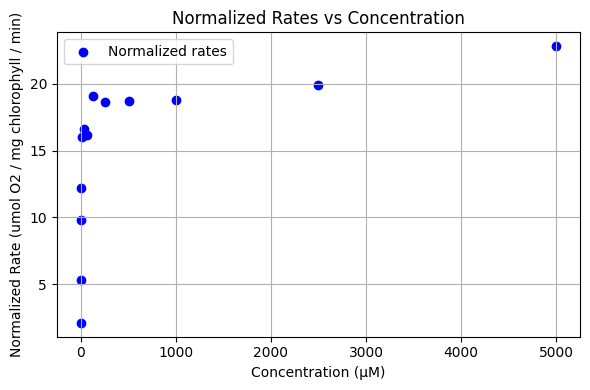

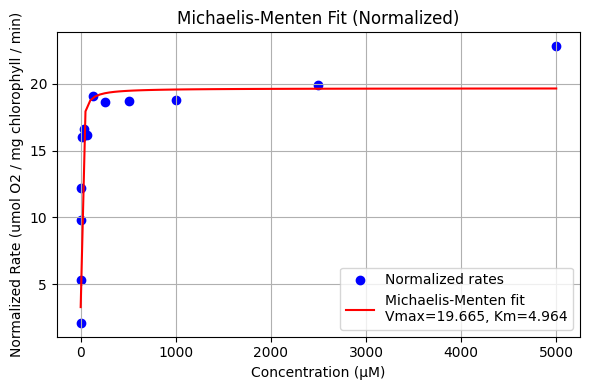

In [ ]:
import pandas as pd

# ---------------------------
# Load Recorded Rates Data
# ---------------------------
data = pd.read_csv(f"{basename}_recorded_rates.csv")

# Sort by concentration (just for clean plotting)
data = data.sort_values(by="Concentration (uM)")

# Get chlorophyll input and units from the widgets
def normalize_rate(change=None):
    chlorophyll_amount = chlorophyll_input.value
    unit = unit_dropdown.value

    if chlorophyll_amount <= 0:
        print("Please input a valid chlorophyll amount.")
        return


    # Normalize the rates based on chlorophyll amount and units
    if unit == 'umol oxygen per mg chlorophyll per hour':
        normalization_factor = chlorophyll_amount * 0.72  # Convert to per minute
    elif unit == 'umol oxygen per mg chlorophyll per min':
        normalization_factor = chlorophyll_amount * 0.72 / 60

    # Normalize the rates (assuming 'Rate' column is in nmol per minute)
    data["Normalized Rate"] = data["Rate"] * normalization_factor

    # Scatter plot for normalized rates
    plt.figure(figsize=(6, 4))
    plt.scatter(data["Concentration (uM)"], data["Normalized Rate"], color='blue', label="Normalized rates")
    plt.xlabel("Concentration (µM)")
    plt.ylabel("Normalized Rate (umol O2 / mg chlorophyll / min)")
    plt.title("Normalized Rates vs Concentration")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Michaelis-Menten function for fitting
    def michaelis_menten(S, Vmax, Km):
        return (Vmax * S) / (Km + S)

    # Fit curve
    popt, pcov = curve_fit(michaelis_menten, data["Concentration (uM)"], data["Normalized Rate"], bounds=(0, np.inf))
    Vmax_fit, Km_fit = popt

    # Generate smooth curve for plotting
    S_fit = np.linspace(data["Concentration (uM)"].min(), data["Concentration (uM)"].max(), 100)
    rate_fit = michaelis_menten(S_fit, *popt)

    # Plot with fit
    plt.figure(figsize=(6, 4))
    plt.scatter(data["Concentration (uM)"], data["Normalized Rate"], color='blue', label="Normalized rates")
    plt.plot(S_fit, rate_fit, color='red', label=f"Michaelis-Menten fit\nVmax={Vmax_fit:.3f}, Km={Km_fit:.3f}")
    plt.xlabel("Concentration (µM)")
    plt.ylabel("Normalized Rate (umol O2 / mg chlorophyll / min)")
    plt.title("Michaelis-Menten Fit (Normalized)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

normalize_rate()